In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_squared_error
from matplotlib import cm

### BindingDB - Comparing models on each data split

In [2]:
# Load the data from CSV files
bindingdb_random = pd.read_csv('clean_expts/bindingdb_random.csv')
bindingdb_cold_target = pd.read_csv('clean_expts/bindingdb_cold_target.csv')
bindingdb_cold_drug = pd.read_csv('clean_expts/bindingdb_cold_drug.csv')
bindingdb_scaffold = pd.read_csv('clean_expts/bindingdb_scaffold.csv')

# Add a 'Split' column to each DataFrame
bindingdb_random['Split'] = 'Random'
bindingdb_cold_target['Split'] = 'Cold Target'
bindingdb_cold_drug['Split'] = 'Cold Drug'
bindingdb_scaffold['Split'] = 'Scaffold'

# Combine all the DataFrames into one
combined_data = pd.concat([bindingdb_random, bindingdb_cold_target, bindingdb_cold_drug, bindingdb_scaffold])

# Melt the DataFrame to format it for seaborn
metrics = ['test/ci', 'test/pearson', 'test/spearman', 'test/rmse']
combined_melted = combined_data.melt(id_vars=['Model', 'Split'], value_vars=metrics, var_name='Metric', value_name='Value')
combined_melted['Metric'] = combined_melted['Metric'].map({
    'test/ci': 'CI', 
    'test/pearson': 'Pearson', 
    'test/spearman': 'Spearman', 
    'test/rmse': 'RMSE'
})
#combined_melted.to_csv('clean_expts/combined_data.csv')

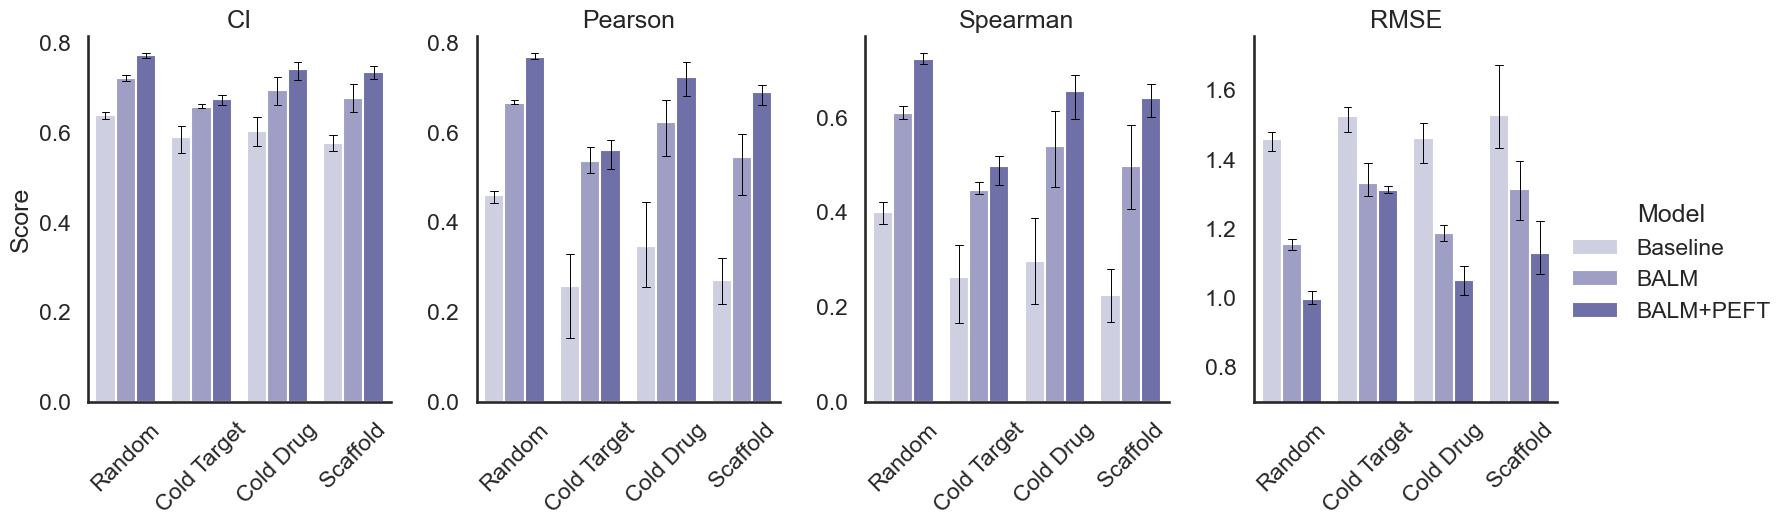

In [3]:
font_sizes = {
    "axes.labelsize": 18,   
    "axes.titlesize": 16,   
    "xtick.labelsize": 18,  
    "ytick.labelsize": 19,
    "legend.fontsize": 16,  
    "font.size": 16       
}
sns.set_style("white")
sns.set_context("talk", rc={"font.size": 14})

# Define a custom Slate Blue color palette using shades of #6A5ACD
slate_blue_colors = sns.color_palette([
    (0.8, 0.8, 0.9),  # very light slate blue
    (0.6, 0.6, 0.8),  # light slate blue
    (0.4, 0.4, 0.7),  # medium slate blue
    (0.2, 0.2, 0.6),  # dark slate blue
])

# Create the catplot with thin error bars
g = sns.catplot(
    data=combined_melted, 
    x="Split", 
    y="Value", 
    col="Metric", 
    hue="Model", 
    kind="bar", 
    sharey=False,
    hue_order=["Baseline", "BALM", "BALM+PEFT"], 
    palette=slate_blue_colors,
    height=5, 
    aspect=0.8,
    errorbar=("ci", 95),  # Use confidence intervals (CI) for error bars
    errwidth=0.7,  # Set the width of the error bars
    capsize=0.1,   # Set the cap size (length of the error bar caps)
    errcolor='black',  # Set the color of the error bars
)

# Set plot titles and labels
g.set_titles("{col_name}")
g.set_axis_labels("", "Score")
g.set_xticklabels(rotation=45)

# Remove the top and right axes lines
sns.despine()

# Adjust ylim for a specific plot
num_splits = combined_melted['Split'].nunique()
for i, ax in enumerate(g.axes.flat):
    if i == 3:
        ax.set_ylim(bottom=0.7)

# Show the plot
plt.show()


### PEFT Analysis

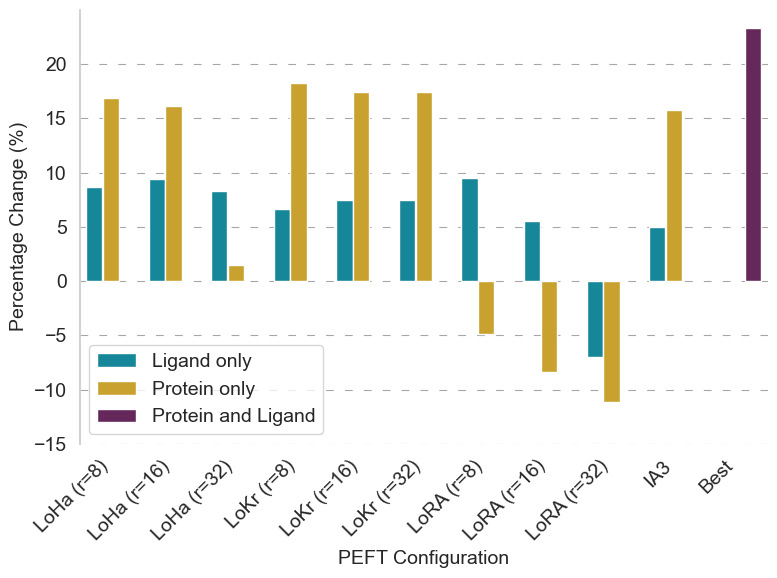

In [4]:
from matplotlib.colors import ListedColormap

# Load and preprocess the data
file_path = 'clean_expts/data_peft_final.csv'
data = pd.read_csv(file_path)
data.columns = data.columns.str.strip()  # Strip extra spaces from column names

# Calculate the baseline 'test/pearson' where both 'PEFT' and 'Fine-tuning' are 'No'
baseline_pearson = data.loc[(data['PEFT'] == 'No') & (data['Fine-tuning'] == 'No'), 'test/pearson'].mean()

# Percentage change in 'test/pearson' relative to the baseline
data['percentage_change_pearson'] = (data['test/pearson'] - baseline_pearson) / baseline_pearson * 100

# Filter out the 'No' PEFT configuration and separate the 'Best' category
filtered_data = data[(data['PEFT'] != 'No') & (data['PEFT'] != 'Best')]
best_data = data[data['PEFT'] == 'Best']

# Insert 'Best' category at the end
filtered_data = pd.concat([filtered_data, best_data])

# Adjust font sizes for plot aesthetics
font_sizes = {
    "axes.labelsize": 14,   # Axis labels
    "axes.titlesize": 14,   # Title
    "xtick.labelsize": 14,  # X-axis tick labels
    "ytick.labelsize": 14,  # Y-axis tick labels
    "legend.fontsize": 14,  # Legend
    "font.size": 14         # General font size
}

# Set plot style and context
sns.set_style("whitegrid")
sns.set_context("notebook", rc=font_sizes)

# Define custom colors for the plot
custom_palette = {'Ligand only': '#0096AF', 'Protein only': '#E1AD15', 'Protein and Ligand': '#6E1E62'}

# Prepare the plot
plt.figure(figsize=(8, 6))
g = sns.barplot(x='PEFT', y='percentage_change_pearson', hue='Fine-tuning', data=filtered_data, palette=custom_palette, dodge=True)

# Set plot titles and labels
g.set_xlabel('PEFT Configuration')
g.set_ylabel('Percentage Change (%)')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# Add faint dashed guiding lines at every 5% interval, including negative values
ax = plt.gca()
ax.set_yticks(np.arange(-15, 25, 5))
ax.set_ylim(-15, 25)
ax.yaxis.grid(True, linestyle=(0, (7, 10)), linewidth=0.8, color='grey', alpha=0.7)  # Set grid with specific style

# Enable only the left spine and spine at 0%
for spine in ['top', 'right', 'bottom']:
    ax.spines[spine].set_visible(False)
ax.spines['left'].set_visible(True)

# Adjust the width of the bars
for bar in g.patches:
    bar.set_width(0.26)  # Make bars thinner

# Add legend
plt.legend(title='', loc='lower left')

# Tight layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()



### Cold Target Analysis

In [5]:
# Set random seed and visualization styles
np.random.seed(42)
sns.set_style("white")
sns.set_context("talk", rc={"font.size": 14})

In [6]:
# Fisher transformation and inverse Fisher transformation
def fisher_transformation(r):
    return 0.5 * np.log((1 + r) / (1 - r))

def inverse_fisher_transformation(z):
    return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)

# Define function to compute statistics for a given file and apply Fisher transformation
def compute_stats_with_fisher(file_path):
    data = pd.read_csv(file_path)
    data = data.replace([np.inf, -np.inf], np.nan).dropna(subset=['label', 'prediction'])
    target_counts = data['protein'].value_counts()
    targets_to_include = target_counts[target_counts >= 10].index
    filtered_data = data[data['protein'].isin(targets_to_include)]

    fisher_pearson_values, fisher_spearman_values, individual_rmse = [], [], []

    for target in filtered_data['protein'].unique():
        target_data = filtered_data[filtered_data['protein'] == target]
        if len(target_data) >= 2:
            pearson_corr, _ = pearsonr(target_data['label'], target_data['prediction'])
            spearman_corr, _ = spearmanr(target_data['label'], target_data['prediction'])
            fisher_pearson_values.append(fisher_transformation(pearson_corr))
            fisher_spearman_values.append(fisher_transformation(spearman_corr))
            individual_rmse.append(np.sqrt(np.mean((target_data['label'] - target_data['prediction'])**2)))

    mean_fisher_pearson = inverse_fisher_transformation(np.mean(fisher_pearson_values))
    mean_fisher_spearman = inverse_fisher_transformation(np.mean(fisher_spearman_values))
    mean_rmse_individual = np.mean(individual_rmse)
    std_rmse_individual = np.std(individual_rmse)
    overall_pearson, _ = pearsonr(data['label'], data['prediction'])
    overall_spearman, _ = spearmanr(data['label'], data['prediction'])
    overall_rmse = np.sqrt(np.mean((data['label'] - data['prediction'])**2))

    return {
        "Individual Pearson Fisher Mean": mean_fisher_pearson,
        "Individual Spearman Fisher Mean": mean_fisher_spearman,
        "Individual RMSE Mean": mean_rmse_individual,
        "Individual RMSE Std": std_rmse_individual,
        "Overall Pearson": overall_pearson,
        "Overall Spearman": overall_spearman,
        "Overall RMSE": overall_rmse
    }
# Define function to calculate metrics (Pearson and Spearman)
def calculate_metrics(data):
    pearson_corr, _ = pearsonr(data['label'], data['prediction'])
    spearman_corr, _ = spearmanr(data['label'], data['prediction'])
    return pearson_corr, spearman_corr


In [7]:
# Load and process BALM+PEFT files
file_paths = [
    'cold_target_data/BALM+PEFT_CT1.csv',
    'cold_target_data/BALM+PEFT_CT2.csv',
    'cold_target_data/BALM+PEFT_CT3.csv'
]

# Collect statistics for each file
summary_stats = [compute_stats_with_fisher(file) for file in file_paths]

# Create a summary DataFrame
summary_df = pd.DataFrame(summary_stats)

# Aggregate data for BALM+PEFT model using Fisher-transformed values
def aggregate_model_data_with_fisher(df):
    individual_pearson_fisher_mean = inverse_fisher_transformation(df['Individual Pearson Fisher Mean'].mean())
    individual_spearman_fisher_mean = inverse_fisher_transformation(df['Individual Spearman Fisher Mean'].mean())
    individual_rmse_mean = df['Individual RMSE Mean'].mean()
    individual_rmse_std = df['Individual RMSE Std'].mean()
    overall_pearson_mean = df['Overall Pearson'].mean()
    overall_pearson_std = df['Overall Pearson'].std()
    overall_spearman_mean = df['Overall Spearman'].mean()
    overall_spearman_std = df['Overall Spearman'].std()
    overall_rmse_mean = df['Overall RMSE'].mean()
    overall_rmse_std = df['Overall RMSE'].std()

    return {
        "Aggregated Pearson Fisher Mean": individual_pearson_fisher_mean,
        "Aggregated Spearman Fisher Mean": individual_spearman_fisher_mean,
        "RMSE Mean": individual_rmse_mean,
        "RMSE Std": individual_rmse_std,
        "Overall Pearson Mean": overall_pearson_mean,
        "Overall Pearson Std": overall_pearson_std,
        "Overall Spearman Mean": overall_spearman_mean,
        "Overall Spearman Std": overall_spearman_std,
        "Overall RMSE Mean": overall_rmse_mean,
        "Overall RMSE Std": overall_rmse_std
    }

# Aggregate metrics for the BALM+PEFT model
aggregated_metrics_balm_peft = aggregate_model_data_with_fisher(summary_df)


import pandas as pd

# Load all three BALM+PEFT datasets
files = [
    'cold_target_data/BALM+PEFT_CT1.csv',
    'cold_target_data/BALM+PEFT_CT2.csv',
    'cold_target_data/BALM+PEFT_CT3.csv'
]

# Read datasets into a list of dataframes
dfs = [pd.read_csv(file) for file in files]

# Filter for targets present in all three datasets and with at least 20 interactions
common_targets = set(dfs[0]['protein'])
for df in dfs[1:]:
    common_targets.intersection_update(df['protein'])

# Filter the datasets for common targets with at least 20 interactions in each dataset
filtered_dfs = []
for df in dfs:
    target_counts = df['protein'].value_counts()
    valid_targets = target_counts[target_counts >= 20].index
    df_filtered = df[df['protein'].isin(valid_targets)]
    filtered_dfs.append(df_filtered)

# Get the list of common targets
common_filtered_targets = set(filtered_dfs[0]['protein'])
for df in filtered_dfs[1:]:
    common_filtered_targets.intersection_update(df['protein'])

# Filter the dataframes again for these final common targets
final_dfs = [df[df['protein'].isin(common_filtered_targets)] for df in filtered_dfs]
final_dfs

[      Unnamed: 0                                            protein   
 26            26  MMLSLNNLQNIIYNPVIPFVGTIPDQLDPGTLIVIRGHVPSDADRF...  \
 88            88  MMLSLNNLQNIIYNPVIPFVGTIPDQLDPGTLIVIRGHVPSDADRF...   
 92            92  MMLSLNNLQNIIYNPVIPFVGTIPDQLDPGTLIVIRGHVPSDADRF...   
 97            97  MMLSLNNLQNIIYNPVIPFVGTIPDQLDPGTLIVIRGHVPSDADRF...   
 99            99  MMLSLNNLQNIIYNPVIPFVGTIPDQLDPGTLIVIRGHVPSDADRF...   
 195          195  MMLSLNNLQNIIYNPVIPFVGTIPDQLDPGTLIVIRGHVPSDADRF...   
 562          562  MMLSLNNLQNIIYNPVIPFVGTIPDQLDPGTLIVIRGHVPSDADRF...   
 659          659  MMLSLNNLQNIIYNPVIPFVGTIPDQLDPGTLIVIRGHVPSDADRF...   
 661          661  MMLSLNNLQNIIYNPVIPFVGTIPDQLDPGTLIVIRGHVPSDADRF...   
 662          662  MMLSLNNLQNIIYNPVIPFVGTIPDQLDPGTLIVIRGHVPSDADRF...   
 664          664  MMLSLNNLQNIIYNPVIPFVGTIPDQLDPGTLIVIRGHVPSDADRF...   
 665          665  MMLSLNNLQNIIYNPVIPFVGTIPDQLDPGTLIVIRGHVPSDADRF...   
 673          673  MMLSLNNLQNIIYNPVIPFVGTIPDQLDPGTLIVIRGHVPSDADR

#### Load Updated Data and Filter for Targets

In [8]:
# Load the updated data for plotting
file_path_updated = 'cold_target_data/updated_BDB_clean_test_pred_cold_target.csv'
updated_data = pd.read_csv(file_path_updated)

# Calculate Pearson correlations and filter for representative targets
target_stats = updated_data.groupby('Target_ID').agg(
    mean_pKD=('label', 'mean'),
    std_pKD=('label', 'std'),
    n_interactions=('label', 'size'),
    pearson_corr=('label', lambda x: pearsonr(x, updated_data.loc[x.index, 'prediction'])[0] if len(x) > 1 else np.nan),
    spearman_corr=('label', lambda x: spearmanr(x, updated_data.loc[x.index, 'prediction'])[0] if len(x) > 1 else np.nan)
).reset_index()

# Filter out targets with less than 10 interactions
target_stats = target_stats[target_stats['n_interactions'] >= 10]


In [9]:
# Set correlation thresholds and select targets based on correlations
np.random.seed(42)
low_corr_threshold = 0.1
high_corr_threshold = 0.3
low_corr_threshold_value = target_stats['pearson_corr'].quantile(low_corr_threshold)
high_corr_threshold_value = target_stats['pearson_corr'].quantile(high_corr_threshold)

# Randomly select targets within the defined correlation ranges
low_corr_target = np.random.choice(target_stats[target_stats['pearson_corr'] <= low_corr_threshold_value]['Target_ID'].values)
medium_corr_target = np.random.choice(target_stats[(target_stats['pearson_corr'] > low_corr_threshold_value) & 
                                                   (target_stats['pearson_corr'] < high_corr_threshold_value)]['Target_ID'].values)
high_corr_target = np.random.choice(target_stats[target_stats['pearson_corr'] >= high_corr_threshold_value]['Target_ID'].values)

# Filter data for each selected target
low_data = updated_data[updated_data['Target_ID'] == low_corr_target]
medium_data = updated_data[updated_data['Target_ID'] == medium_corr_target]
high_data = updated_data[updated_data['Target_ID'] == high_corr_target]


#### Scatter code

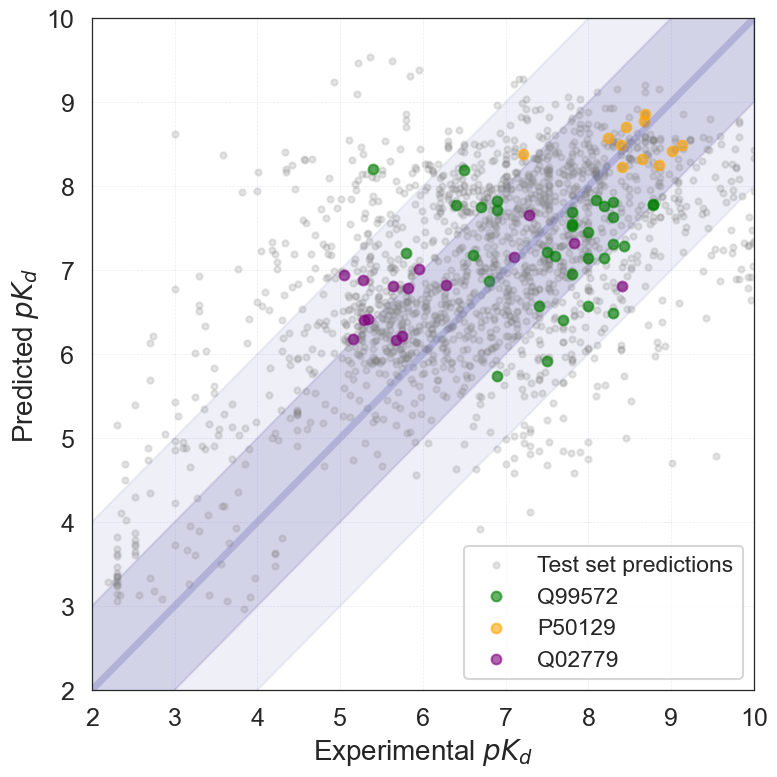

In [10]:
slate_blue_colors = sns.color_palette([
    (0.8, 0.8, 0.9),  # very light slate blue
    (0.6, 0.6, 0.8),  # light slate blue
    (0.4, 0.4, 0.7),  # medium slate blue
    (0.2, 0.2, 0.6),  # dark slate blue
])
# Define colors for the plots
scatter_colors = {'Low Corr': 'green', 'Medium Corr': 'orange', 'High Corr': 'purple'}
bar_colors = {
    'Low Corr': 'green', 'Medium Corr': 'orange', 'High Corr': 'purple',
    'Overall': (0.4, 0.4, 0.7), 'Fisher': (0.6, 0.6, 0.8)
}

# Create combined scatter plot
plt.figure(figsize=(8, 8))

# Set limits for x and y axes
plt.xlim(2, 10)
plt.ylim(2, 10)

# Identity line and shaded bands
x = np.linspace(2, 10, 100)
y = x

# Identity line and shaded bands using slate blue colors
plt.plot(x, y, color=(0.4, 0.4, 0.7), linestyle='-', linewidth=5, alpha=0.3)  # Dark slate blue identity line
plt.fill_between(x, y - 1, y + 1, color=(0.4, 0.4, 0.7), alpha=0.2)  # Medium slate blue shaded band (±1)
plt.fill_between(x, y - 2, y + 2, color=(0.4, 0.4, 0.7), alpha=0.1)  # Light slate blue shaded band (±2)

# Add faint grid lines using slate_blue_colors[1] with alpha=0.2
plt.grid(visible=True, which='both', color=(0.6, 0.6, 0.8), linestyle='--', linewidth=0.5, alpha=0.2)
# Plot all data in grey with low alpha for background, label as "Test set predictions"
plt.scatter(updated_data['label'], updated_data['prediction'], color='grey', alpha=0.2, s=20, label="Test set predictions")

# Overlay selected targets with scatter colors and alpha=0.6
for target_data, color, label in zip([low_data, medium_data, high_data], 
                                     [scatter_colors['Low Corr'], scatter_colors['Medium Corr'], scatter_colors['High Corr']], 
                                     [low_corr_target, medium_corr_target, high_corr_target]):
    plt.scatter(target_data['label'], target_data['prediction'], color=color, alpha=0.6, s=50, label=f'{label}')



# Labels and layout
plt.ylabel(r'Predicted $pK_d$', fontsize=20)
plt.xlabel(r'Experimental $pK_d$', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='best')
plt.tight_layout()

for spine in plt.gca().spines.values():
    spine.set_linewidth(0.9)  # Set spine width to 0.5
# Save the scatter plot
# plt.savefig(os.path.join('plots_Fig2', 'scatter_plot_final.png'), dpi=500)
# plt.savefig(os.path.join('plots_Fig2', 'scatter_plot_final.svg'), dpi=500)
plt.show()


#### Bar plots

In [11]:
# Prepare the Pearson and Spearman bar plots with manual error bars
# Calculate the Fisher aggregated Pearson and Spearman means and standard deviations
fisher_pearson_values = [inverse_fisher_transformation(fisher_transformation(df['prediction'].corr(df['label']))) for df in final_dfs]
fisher_pearson_mean = np.mean(fisher_pearson_values)
fisher_pearson_std = np.std(fisher_pearson_values)

fisher_spearman_values = [inverse_fisher_transformation(fisher_transformation(df['prediction'].corr(df['label'], method='spearman'))) for df in final_dfs]
fisher_spearman_mean = np.mean(fisher_spearman_values)
fisher_spearman_std = np.std(fisher_spearman_values)

# Ensure that the low, medium, and high metrics are defined based on selected targets
low_metrics = calculate_metrics(low_data)
medium_metrics = calculate_metrics(medium_data)
high_metrics = calculate_metrics(high_data)


# Define the metrics DataFrames
metrics_pearson = pd.DataFrame({
    'Target': [low_corr_target, medium_corr_target, high_corr_target, 'Overall', 'Fisher'],
    'Pearson': [low_metrics[0], medium_metrics[0], high_metrics[0], aggregated_metrics_balm_peft['Overall Pearson Mean'], fisher_pearson_mean],
    'Pearson Std': [0, 0, 0, aggregated_metrics_balm_peft['Overall Pearson Std'], fisher_pearson_std]
})

metrics_spearman = pd.DataFrame({
    'Target': [low_corr_target, medium_corr_target, high_corr_target, 'Overall', 'Fisher'],
    'Spearman': [low_metrics[1], medium_metrics[1], high_metrics[1], aggregated_metrics_balm_peft['Overall Spearman Mean'], fisher_spearman_mean],
    'Spearman Std': [0, 0, 0, aggregated_metrics_balm_peft['Overall Spearman Std'], fisher_spearman_std]
})




# Define colors for each bar (target bars have alpha = 0.6, overall and fisher have alpha = 1)
bar_colors_alpha = [
    scatter_colors['Low Corr'], scatter_colors['Medium Corr'], scatter_colors['High Corr'],
    bar_colors['Overall'], bar_colors['Fisher']
]




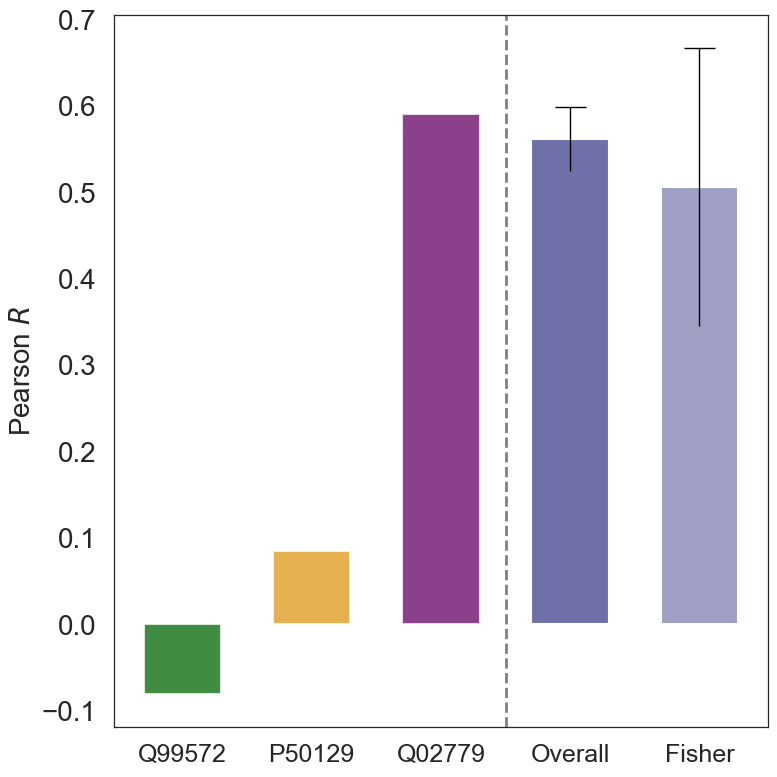

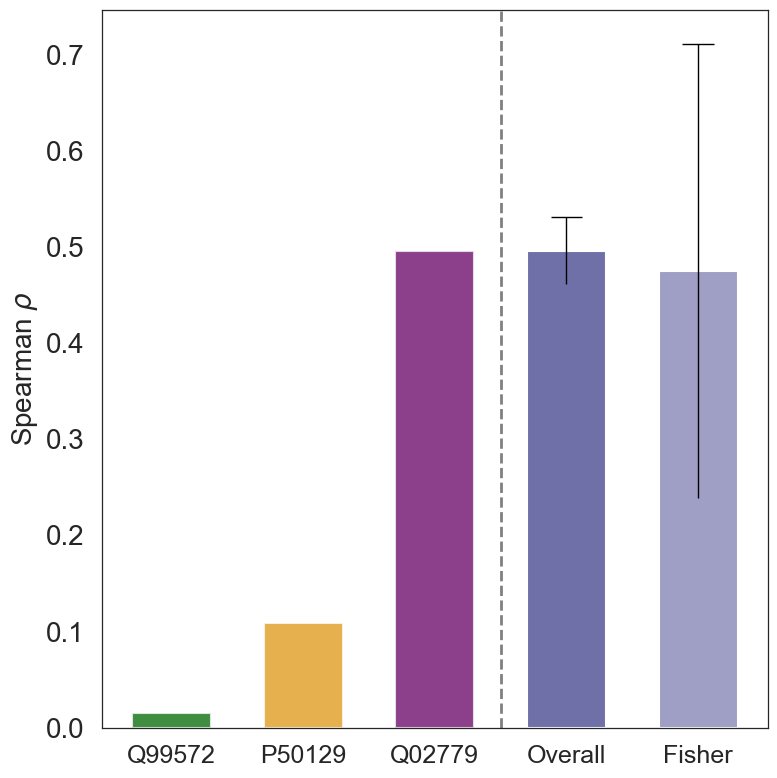

In [12]:
# Plotting Pearson with manual error bars
plt.figure(figsize=(8, 8))

# Adjust bar width by setting width parameter
bars = sns.barplot(x='Target', y='Pearson', data=metrics_pearson, palette=bar_colors_alpha, width=0.6)  # Reduce bar width

# Manually set alpha for each bar
for bar, label in zip(bars.patches, metrics_pearson['Target']):
    if label in [low_corr_target, medium_corr_target, high_corr_target]:
        bar.set_alpha(0.8)  # Set alpha for target bars
    else:
        bar.set_alpha(1)  # Set alpha for Overall and Fisher Aggregated

# Add manual error bars, skip if std is 0
for bar, std in zip(bars.patches, metrics_pearson['Pearson Std']):
    if std != 0:
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_height()
        plt.errorbar(x=x, y=y, yerr=std, fmt='none', color='black', lw=1, capsize=0)
        plt.hlines(y=y + std, xmin=x - bar.get_width() * 0.2, xmax=x + bar.get_width() * 0.2, color='black', lw=1)

# Customize the plot
plt.axvline(2.5, linestyle='--', color='grey', lw=2)
plt.ylabel(r'Pearson $R$', fontsize=20)
plt.xlabel('', fontsize=20)

# Center the x-ticks (x-labels) and reduce rotation angle
plt.xticks(fontsize=18, ha='center')
plt.yticks(fontsize=20)
plt.tight_layout()

# Adjust spine width
for spine in plt.gca().spines.values():
    spine.set_linewidth(0.9)

# Save the Pearson plot
# plt.savefig(os.path.join('plots', 'pearson_bar_plot_final.png'), dpi=500)
# plt.savefig(os.path.join('plots', 'pearson_bar_plot_final.svg'), dpi=500)
plt.show()

# Plotting Spearman with manual error bars
plt.figure(figsize=(8, 8))

# Adjust bar width by setting width parameter
bars = sns.barplot(x='Target', y='Spearman', data=metrics_spearman, palette=bar_colors_alpha, width=0.6)  # Reduce bar width

# Manually set alpha for each bar
for bar, label in zip(bars.patches, metrics_spearman['Target']):
    if label in [low_corr_target, medium_corr_target, high_corr_target]:
        bar.set_alpha(0.8)  # Set alpha for target bars
    else:
        bar.set_alpha(1)  # Set alpha for Overall and Fisher Aggregated

# Add manual error bars, skip if std is 0
for bar, std in zip(bars.patches, metrics_spearman['Spearman Std']):
    if std != 0:
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_height()
        plt.errorbar(x=x, y=y, yerr=std, fmt='none', color='black', lw=1, capsize=0)
        plt.hlines(y=y + std, xmin=x - bar.get_width() * 0.2, xmax=x + bar.get_width() * 0.2, color='black', lw=1)

# Customize the plot
plt.axvline(2.5, linestyle='--', color='grey', lw=2)
plt.ylabel(r'Spearman $\rho$', fontsize=20)
plt.xlabel('', fontsize=20)
# Center the x-ticks (x-labels) and reduce rotation angle
plt.xticks(fontsize=18, ha='center')
plt.yticks(fontsize=20)
plt.tight_layout()

# Adjust spine width
for spine in plt.gca().spines.values():
    spine.set_linewidth(0.9)

# Save the Spearman plot
# plt.savefig(os.path.join('plots', 'spearman_bar_plot_final.png'), dpi=500)
# plt.savefig(os.path.join('plots', 'spearman_bar_plot_final.svg'), dpi=500)
plt.show()


### BindingDB Clean Zero Shot performance across all targets in test set with atleast 10 interactions

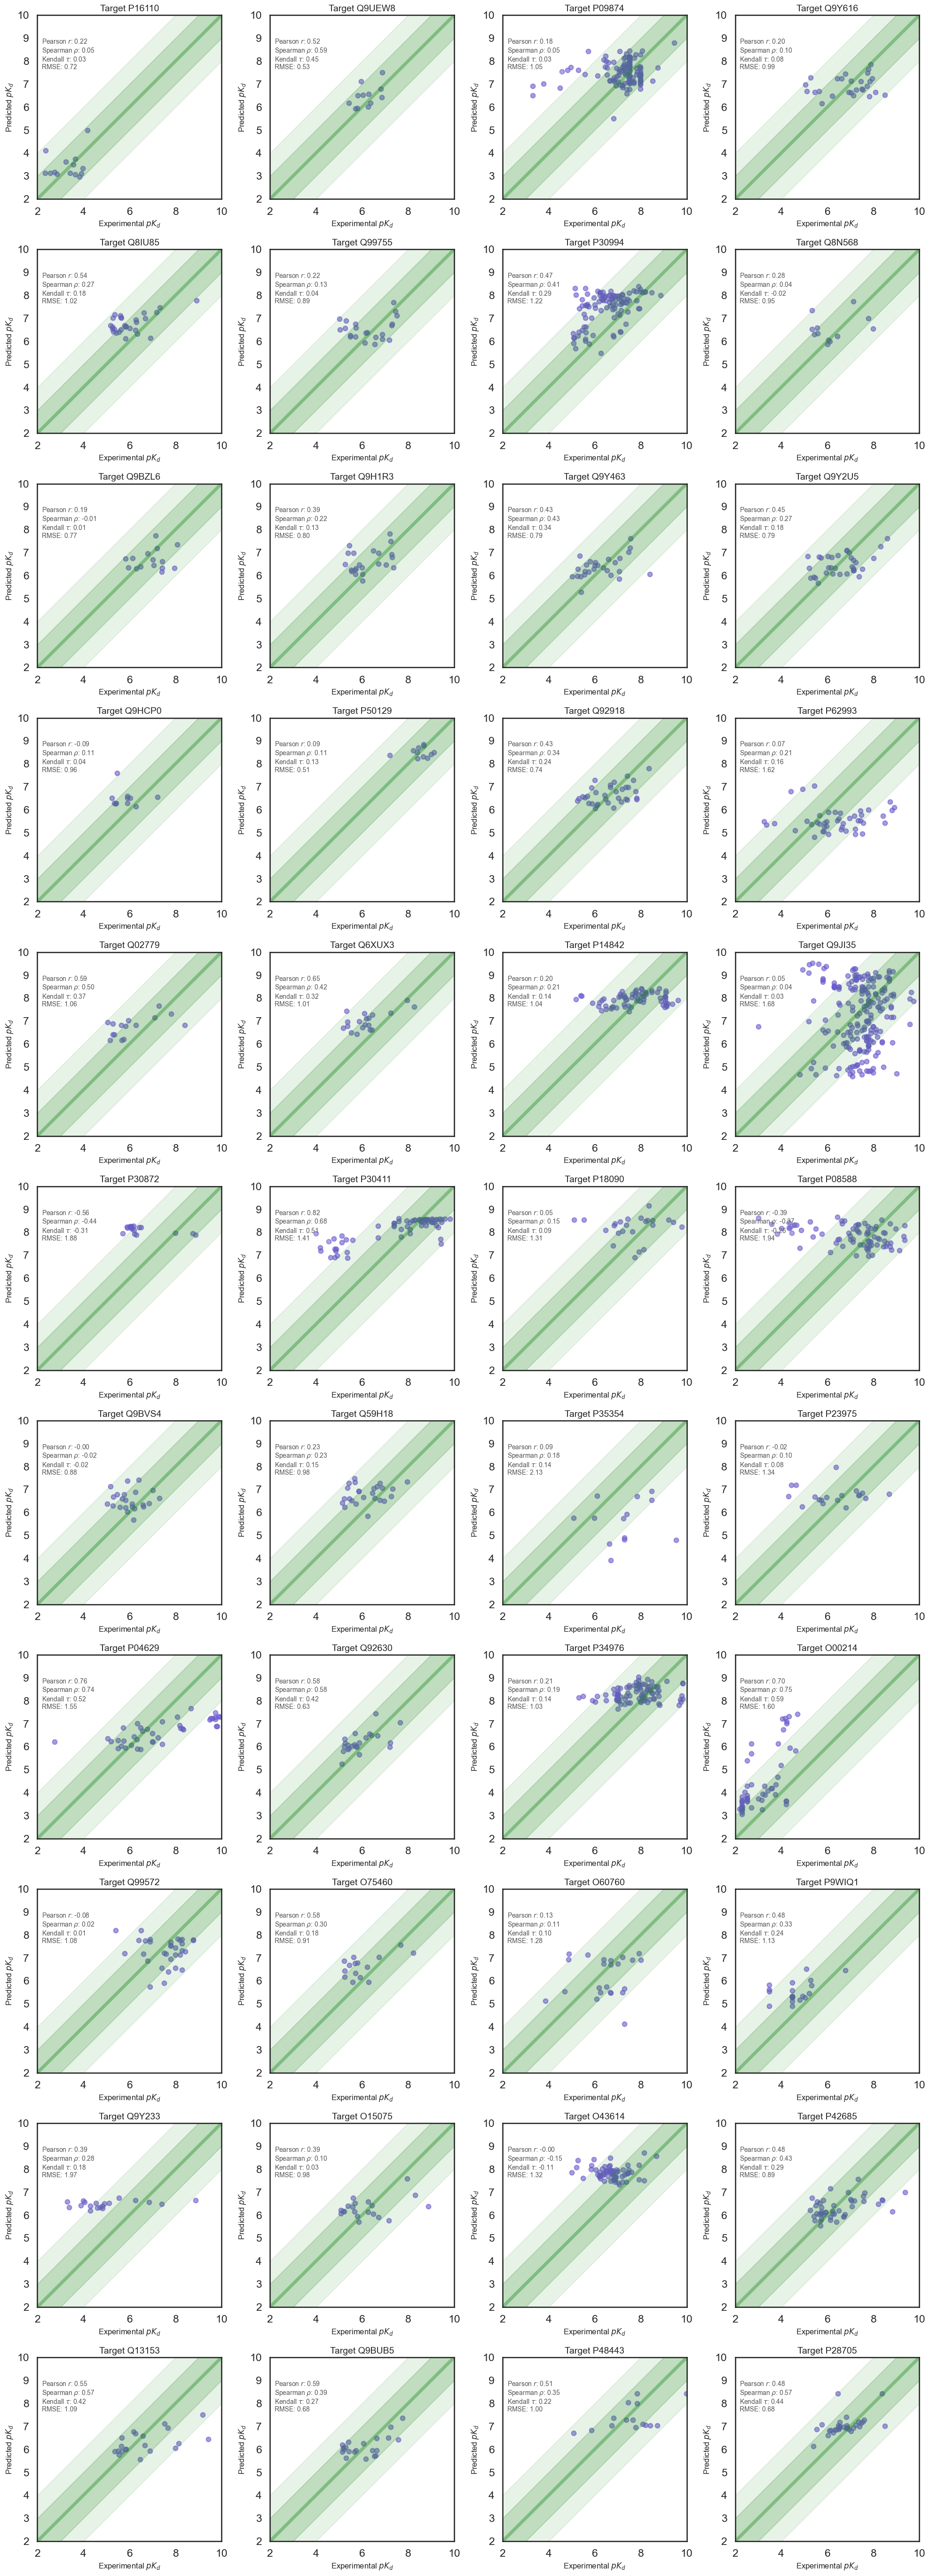

In [14]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.metrics import mean_squared_error

# Load the data
file_path = 'cold_target_data/updated_BDB_clean_test_pred_cold_target.csv'
data = pd.read_csv(file_path)

# Filter targets with at least 10 data points
target_counts = data['Target_ID'].value_counts()
targets_to_plot = target_counts[target_counts >= 10].index

# Now filter the data to only include these targets
filtered_data = data[data['Target_ID'].isin(targets_to_plot)]

# Get unique targets after filtering
unique_targets = filtered_data['Target_ID'].unique()
n_targets = len(unique_targets)

# Define the number of rows and columns for subplots
n_cols = 4  # You can adjust this number as needed
n_rows = (n_targets // n_cols) + (n_targets % n_cols > 0)

# Create a figure and subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()

# Plotting for each target
for i, target in enumerate(unique_targets):
    target_data = filtered_data[filtered_data['Target_ID'] == target]
    ax = axes[i]
    
    if len(target_data) < 2:
        pearson_corr, spearman_corr, kendall_corr, rmse = "NA", "NA", "NA", "NA"
    else:
        # Calculate Pearson, Spearman, Kendall correlations
        pearson_corr, _ = pearsonr(target_data['label'], target_data['prediction'])
        spearman_corr, _ = spearmanr(target_data['label'], target_data['prediction'])
        kendall_corr, _ = kendalltau(target_data['label'], target_data['prediction'])

        # Calculate RMSE
        rmse = mean_squared_error(target_data['label'], target_data['prediction'], squared=False)

        # Formatting the values
        pearson_corr = f"{pearson_corr:.2f}"
        spearman_corr = f"{spearman_corr:.2f}"
        kendall_corr = f"{kendall_corr:.2f}"
        rmse = f"{rmse:.2f}"

    # Scatter plot
    ax.scatter(target_data['label'], target_data['prediction'], color='#6A5ACD', alpha=0.6, s=50)  # Slate Blue
    
    # Adding identity line with shaded bands using Forest Green
    x = np.linspace(2, 10, 100)
    y = x
    ax.plot(x, y, color='#228B22', linestyle='-', linewidth=5, alpha=0.4)  # Forest Green line
    ax.fill_between(x, y - 1, y + 1, color='#228B22', alpha=0.2)  # Green shade
    ax.fill_between(x, y - 2, y + 2, color='#228B22', alpha=0.1)  # Light Green shade

    ax.set_xlim(2, 10)
    ax.set_ylim(2, 10)

    # Labels and titles
    ax.set_ylabel(r'Predicted $pK_d$', fontsize=12)
    ax.set_xlabel(r'Experimental $pK_d$', fontsize=12)
    ax.set_title(f'Target {target}', fontsize=14)

    # Add text for Pearson, Spearman, Kendall correlations, and RMSE
    ax.text(2.2, 9.0, 
            f'Pearson $r$: {pearson_corr}\nSpearman $\\rho$: {spearman_corr}\nKendall $\\tau$: {kendall_corr}\nRMSE: {rmse}', 
            fontsize=10, verticalalignment='top', color='#555555',  # Slate Blue for text
            bbox=dict(facecolor='white', alpha=0.1, edgecolor='white'))

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()

# Save the combined figure
# plt.savefig('BDB_clean_new_10points.png', dpi=500)
plt.show()


### Randomisation experiments

In [16]:
file_path = 'clean_expts/Randomisation.csv'
data = pd.read_csv(file_path)
data.head()

,Model,CI,Pearson,RMSE,Spearman,Protein,Ligand
0,BALM+PEFT,0.633034,0.510124,1.335108,0.380652,Random,Original
1,BALM,0.641020,0.544967,1.302294,0.402137,Random,Original
2,Baseline,0.624292,0.364816,1.488032,0.361866,Random,Original
3,BALM,0.669263,0.517846,1.361324,0.481755,Original,Random
4,BALM+PEFT,0.717625,0.637302,1.226673,0.599201,Original,Random


In [17]:
melted_data = pd.melt(data, id_vars=['Model', 'Protein', 'Ligand'], value_vars=['Pearson', 'Spearman', 'RMSE'])
melted_data.rename(columns={'variable': 'Metric', 'value': 'Value'}, inplace=True)

# Combine Protein and Ligand into a single column for plotting on x-axis
melted_data['Protein_Ligand'] = melted_data['Protein'] + ' Protein - ' + melted_data['Ligand'] + ' Ligand'
melted_data_filtered = melted_data[melted_data['Metric'] != "CI"]

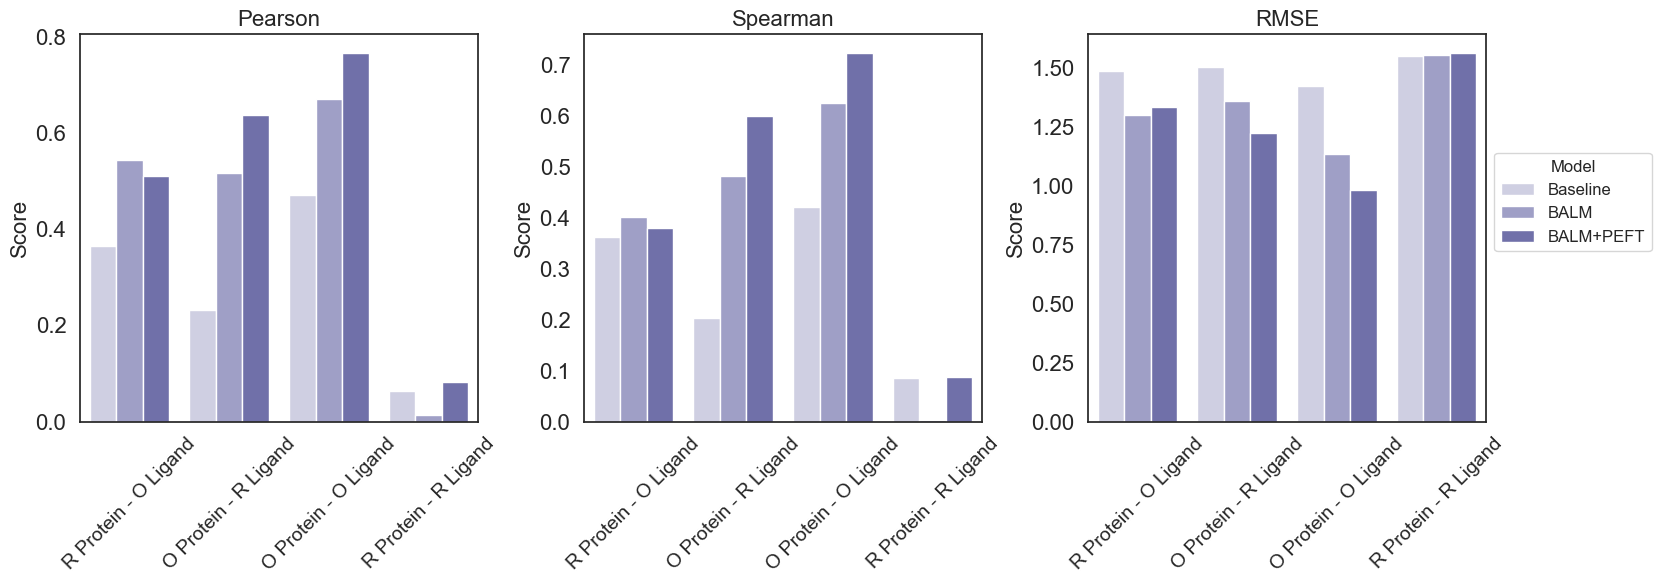

In [18]:
sns.set(style="white")

custom_palette = sns.color_palette([
    (0.8, 0.8, 0.9),  # very light slate blue
    (0.6, 0.6, 0.8),  # light slate blue
    (0.4, 0.4, 0.7),  # medium slate blue
    (0.2, 0.2, 0.6),  # dark slate blue
])

# sns.color_palette([
#     (0.7, 0.8, 0.7),  # light green
#     (0.5, 0.7, 0.7),  # light teal
#     (0.3, 0.6, 0.6),  # medium teal
#     (0.2, 0.5, 0.5),  # darker teal
# ])
metrics = ["Pearson", "Spearman", "RMSE"]
hue_order=["Baseline", "BALM", "BALM+PEFT"]
# Set up the plot with 3 subplots (one for each metric)
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

# Iterate through the metrics and create individual barplots for each
for i, metric in enumerate(metrics):
    sns.barplot(
        x='Protein_Ligand', y='Value', hue='Model', data=melted_data_filtered[melted_data_filtered['Metric'] == metric], 
        ax=axes[i], palette=custom_palette, hue_order=hue_order
    )
    
    # Set the title and labels for each subplot
    axes[i].set_title(f'{metric}', fontsize=16)
    axes[i].set_ylabel('Score' if metric != 'RMSE' else 'Score', fontsize=16)
    
    # Rotate x-axis labels for better readability and adjust font size
    axes[i].tick_params(axis='x', rotation=45, labelsize=14)
    axes[i].tick_params(axis='y', labelsize=16)
    
    # Replace "Random" with "R" and "Original" with "O" in the x-tick labels
    new_labels = [label.replace('Random', 'R').replace('Original', 'O') for label in melted_data_filtered['Protein_Ligand'].unique()]
    axes[i].set_xticklabels(new_labels)
    
    axes[i].set_xlabel('')
    axes[i].legend_.remove()


handles, labels = axes[2].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.83, 0.65), title='Model', fontsize=12)

# Adjust the layout to accommodate the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])
fig.savefig( 'plots/Random_expts' + '.png', dpi=500, bbox_inches='tight')
plt.show()
